<a href="https://colab.research.google.com/github/Mayur141996/Module3-Lab1/blob/main/Module4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
 # innstall java
!apt-get install openjdk-8-jdk-headless -qq > /dev/null

# install spark (change the version number if needed)
!wget -q https://archive.apache.org/dist/spark/spark-3.0.0/spark-3.0.0-bin-hadoop3.2.tgz

# unzip the spark file to the current folder
!tar xf spark-3.0.0-bin-hadoop3.2.tgz

# set your spark folder to your system path environment. 
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.0.0-bin-hadoop3.2"


# install findspark using pip
!pip install -q findspark

In [4]:
import findspark
findspark.init()
from pyspark.sql import SparkSession
spark = SparkSession.builder.master("local[*]").getOrCreate()

In [5]:
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import LinearRegression
from pyspark.ml.feature import VectorAssembler, StandardScaler, PCA
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [6]:
from google.colab import files
uploaded = files.upload()

Saving InsurancePrices.csv to InsurancePrices.csv


In [7]:
dataset = spark.read.csv('InsurancePrices.csv', inferSchema=True, header = True)

In [8]:
dataset.show(5)

+---+------+------+--------+------+---------+-----------+
|age|   sex|   bmi|children|smoker|   region|    charges|
+---+------+------+--------+------+---------+-----------+
| 19|female|  27.9|       0|     1|southwest|  16884.924|
| 18|  male| 33.77|       1|     0|southeast|  1725.5523|
| 28|  male|  33.0|       3|     0|southeast|   4449.462|
| 33|  male|22.705|       0|     0|northwest|21984.47061|
| 32|  male| 28.88|       0|     0|northwest|  3866.8552|
+---+------+------+--------+------+---------+-----------+
only showing top 5 rows



In [9]:
row = dataset.count()
print(row)

1338


In [10]:
dataset.printSchema()

root
 |-- age: integer (nullable = true)
 |-- sex: string (nullable = true)
 |-- bmi: double (nullable = true)
 |-- children: integer (nullable = true)
 |-- smoker: integer (nullable = true)
 |-- region: string (nullable = true)
 |-- charges: double (nullable = true)



In [11]:
dataset.describe().show()

+-------+------------------+------+------------------+-----------------+-------------------+---------+------------------+
|summary|               age|   sex|               bmi|         children|             smoker|   region|           charges|
+-------+------------------+------+------------------+-----------------+-------------------+---------+------------------+
|  count|              1338|  1338|              1338|             1338|               1338|     1338|              1338|
|   mean| 39.20702541106129|  null|30.663396860986538|  1.0949177877429|0.20478325859491778|     null|13270.422265141257|
| stddev|14.049960379216147|  null| 6.098186911679012|1.205492739781914|0.40369403754561717|     null|12110.011236693992|
|    min|                18|female|             15.96|                0|                  0|northeast|         1121.8739|
|    max|                64|  male|             53.13|                5|                  1|southwest|       63770.42801|
+-------+---------------

In [12]:
#Vectorization
only_feature = ['age','bmi','children','smoker']

In [13]:
assembler = VectorAssembler(inputCols=only_feature, outputCol = 'feature')

In [14]:
feat_df = assembler.transform(dataset).select('feature')

In [15]:
feat_df.show(5)

+--------------------+
|             feature|
+--------------------+
| [19.0,27.9,0.0,1.0]|
|[18.0,33.77,1.0,0.0]|
| [28.0,33.0,3.0,0.0]|
|[33.0,22.705,0.0,...|
|[32.0,28.88,0.0,0.0]|
+--------------------+
only showing top 5 rows



In [16]:
#Standardize features for principal component analysis
scaler = StandardScaler(
    inputCol = 'feature',
    outputCol = 'scaledFeature',
    withMean = True,
    withStd = True
).fit(feat_df)

In [17]:
df_scaled = scaler.transform(feat_df)
df_scaled.show(6)

+--------------------+--------------------+
|             feature|       scaledFeature|
+--------------------+--------------------+
| [19.0,27.9,0.0,1.0]|[-1.4382265049624...|
|[18.0,33.77,1.0,0.0]|[-1.5094010828978...|
| [28.0,33.0,3.0,0.0]|[-0.7976553035437...|
|[33.0,22.705,0.0,...|[-0.4417824138666...|
|[32.0,28.88,0.0,0.0]|[-0.5129569918020...|
|[31.0,25.74,0.0,0.0]|[-0.5841315697375...|
+--------------------+--------------------+
only showing top 6 rows



In [18]:
#Train model for two principal component analysis

n_components = 2
pca = PCA(
    k = n_components,
    inputCol = 'scaledFeature',
    outputCol = 'pcafeature').fit(df_scaled)

df_pca = pca.transform(df_scaled)
print("Explained Variance ratio", pca.explainedVariance.toArray())
df_pca.show(6)

Explained Variance ratio [0.28081664 0.25167033]
+--------------------+--------------------+--------------------+
|             feature|       scaledFeature|          pcafeature|
+--------------------+--------------------+--------------------+
| [19.0,27.9,0.0,1.0]|[-1.4382265049624...|[1.76777251917430...|
|[18.0,33.77,1.0,0.0]|[-1.5094010828978...|[0.69305594796664...|
| [28.0,33.0,3.0,0.0]|[-0.7976553035437...|[-0.2183739915014...|
|[33.0,22.705,0.0,...|[-0.4417824138666...|[1.36880709963868...|
|[32.0,28.88,0.0,0.0]|[-0.5129569918020...|[0.76561166594676...|
|[31.0,25.74,0.0,0.0]|[-0.5841315697375...|[1.14702731893090...|
+--------------------+--------------------+--------------------+
only showing top 6 rows



In [19]:
#Collect distributed data in numpy array and then convert to pandas dataframe
X_pca = df_pca.rdd.map(lambda row: row.pcafeature).collect()
X_pca = np.array(X_pca)

In [20]:
X_pca

array([[ 1.76777252, -1.40560238],
       [ 0.69305595,  0.34766961],
       [-0.21837399, -0.38423759],
       ...,
       [ 0.61634291,  0.74003643],
       [ 1.63580921,  0.77443594],
       [-0.43541919, -1.15229014]])

In [21]:
#Convery Array to DF
df_pca = pd.DataFrame(X_pca, columns=['PC1','PC2'])
df_pca.head()

,PC1,PC2
0,1.767773,-1.405602
1,0.693056,0.347670
2,-0.218374,-0.384238
3,1.368807,0.851833
4,0.765612,0.836718


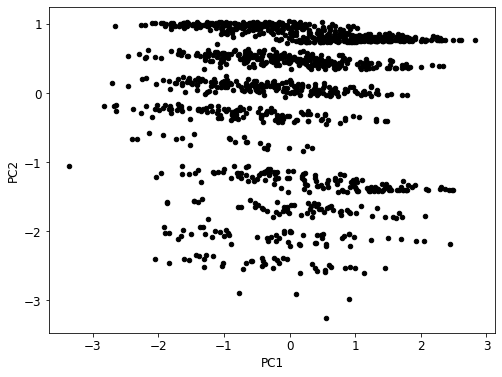

In [22]:
#Plot two principal components
plt.rcParams['figure.figsize'] = 8,6
plt.rcParams['font.size'] = 12
ax1 = df_pca.plot.scatter(x='PC1', y='PC2', c='Black')

In [23]:
#Vectorize features and target together for model development
#Linear Regression


output = assembler.transform(dataset)
#input vs output

finalized_data = output.select('feature','charges')
finalized_data.show()

+--------------------+-----------+
|             feature|    charges|
+--------------------+-----------+
| [19.0,27.9,0.0,1.0]|  16884.924|
|[18.0,33.77,1.0,0.0]|  1725.5523|
| [28.0,33.0,3.0,0.0]|   4449.462|
|[33.0,22.705,0.0,...|21984.47061|
|[32.0,28.88,0.0,0.0]|  3866.8552|
|[31.0,25.74,0.0,0.0]|  3756.6216|
|[46.0,33.44,1.0,0.0]|  8240.5896|
|[37.0,27.74,3.0,0.0]|  7281.5056|
|[37.0,29.83,2.0,0.0]|  6406.4107|
|[60.0,25.84,0.0,0.0]|28923.13692|
|[25.0,26.22,0.0,0.0]|  2721.3208|
|[62.0,26.29,0.0,1.0]| 27808.7251|
| [23.0,34.4,0.0,0.0]|   1826.843|
|[56.0,39.82,0.0,0.0]| 11090.7178|
|[27.0,42.13,0.0,1.0]| 39611.7577|
| [19.0,24.6,1.0,0.0]|   1837.237|
|[52.0,30.78,1.0,0.0]| 10797.3362|
|[23.0,23.845,0.0,...| 2395.17155|
| [56.0,40.3,0.0,0.0]|  10602.385|
| [30.0,35.3,0.0,1.0]|  36837.467|
+--------------------+-----------+
only showing top 20 rows



In [24]:
#Split dataset into training and testing dataset
train_data, test_data = finalized_data.randomSplit([0.8,0.2]) 

In [25]:
#Fitting Model
regressor = LinearRegression(featuresCol='feature', labelCol='charges')

regressor = regressor.fit(train_data)

In [27]:
regressor

LinearRegressionModel: uid=LinearRegression_691be6d1578f, numFeatures=4

In [28]:
#Find out model coefficients and intercept
coeff = regressor.coefficients
intr = regressor.intercept

print("The coef of Model is : %a" %coeff)
print("The Intercept of the model is: %f" %intr)

The coef of Model is : DenseVector([259.5221, 299.9937, 494.9954, 23872.5763])
The Intercept of the model is: -11447.602710


In [29]:
#Evaluate model for test dataset
pred = regressor.evaluate(test_data)

#predict the model
pred.predictions.show()

+--------------------+-----------+-------------------+
|             feature|    charges|         prediction|
+--------------------+-----------+-------------------+
|[18.0,23.21,0.0,0.0]|  1121.8739|  186.6484005445982|
|[18.0,27.28,3.0,1.0]| 18223.4512| 26765.185414268955|
|[18.0,29.165,0.0,...|7323.734819| 1973.1108888320468|
|[18.0,30.03,1.0,0.0]|  1720.3537|  2727.600883193021|
|[18.0,31.92,0.0,0.0]|  2205.9808|  2799.593534546897|
|[18.0,33.77,1.0,0.0]|  1725.5523| 3849.5773241997504|
|[18.0,38.665,2.0,...| 3393.35635|  5813.041932800594|
|[18.0,39.14,0.0,0.0]|12890.05765|  4965.548054351328|
|[18.0,40.185,0.0,...| 2217.46915|  5279.041471691444|
|[18.0,40.28,0.0,0.0]|  2217.6012|  5307.540873267817|
| [19.0,17.8,0.0,0.0]|   1727.785| -1176.795447758299|
| [19.0,18.6,0.0,0.0]|   1728.897| -936.8004871151497|
| [19.0,20.3,0.0,0.0]|    1242.26|-426.81119574845616|
|[19.0,20.425,0.0,...| 1625.43375| -389.3119831479635|
| [19.0,20.6,0.0,0.0]|   1731.677| -336.8130855072741|
| [19.0,20

In [31]:
from pyspark.ml.evaluation import RegressionEvaluator
eval = RegressionEvaluator(labelCol = "charges", predictionCol = "prediction", metricName = "rmse")

#Root Mean Square Error
rmse = eval.evaluate(pred.predictions)
print("RMSE : %f" %rmse)

#mean square error
mse = eval.evaluate(pred.predictions,{eval.metricName: "mse"})
print("MSE: %.3f" % mse)

#mean absolute error
mae = eval.evaluate(pred.predictions,{eval.metricName: "mae"})
print("MAE: %.3f" % mae)

#r2 - coefficient
r2 = eval.evaluate(pred.predictions,{eval.metricName: "r2"})
print("r2: %.3f" % r2)

RMSE : 5426.026016
MSE: 29441758.328
MAE: 3765.000
r2: 0.791
